## 1 - 19.09.25

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import *
from sklearn.preprocessing import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import *

pd.set_option("display.max_columns", None)

import joblib

SEED = 42
n_splits = 8

load and preprocess data

In [ ]:
sample_sub = pd.read_csv("../../../data/ml_01_1.csv")

test = pd.read_csv("../../../data/ml_01_2.csv")
train = pd.read_csv("../../../data/ml_01_3.csv")

train.drop(columns=["PassengerId"], inplace=True)
test.drop(columns=["PassengerId"], inplace=True)


def fe(df: pd.DataFrame):
    df["TotalServiceSpend"] = (
        df["RoomService"]
        + df["FoodCourt"]
        + df["ShoppingMall"]
        + df["Spa"]
        + df["VRDeck"]
    )
    df["ServiceSpendPerAge"] = df["TotalServiceSpend"] / (df["Age"] + 1)
    df[["CabinDeck", "CabinNum", "CabinSide"]] = df["Cabin"].str.split(
        "/", expand=True
    )
    df["LastName"] = df["Name"].str.split().str[-1]
    df["IsFamily"] = df.groupby("LastName")["Name"].transform("size") > 1
    df["AgeGroup"] = pd.cut(
        df["Age"],
        bins=[0, 18, 30, 50, 80],
        labels=["Child", "YoungAdult", "Adult", "Senior"],
    )
    df["TravelAlone"] = (
        df["Cabin"].duplicated(keep=False) | df["IsFamily"]
    ).astype(int)
    df["CryoSleepAndSpent"] = (
        df["CryoSleep"] & (df["TotalServiceSpend"] > 0)
    ).astype(int)
    df["VIPSpendMultiplier"] = df["VIP"] * df["TotalServiceSpend"]

    return df


train = fe(train)
test = fe(test)


def impute(df: pd.DataFrame):
    categorical_cols = [
        "HomePlanet",
        "CryoSleep",
        "Cabin",
        "Destination",
        "AgeGroup",
        "CabinDeck",
    ]
    for col in categorical_cols:
        if col in df.columns and df[col].dtype.name == "category":
            if "NoInformation" not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories("NoInformation")
            df[col].fillna("NoInformation", inplace=True)
        else:
            df[col].fillna("NoInformation", inplace=True)

    vip_threshold = df["VIPSpendMultiplier"].quantile(0.99)
    df["VIP"].fillna(df["VIPSpendMultiplier"] > vip_threshold, inplace=True)
    df["Name"].fillna("noName", inplace=True)
    df["LastName"].fillna("noName", inplace=True)
    df["CabinSide"].fillna(df["CabinSide"].mode()[0], inplace=True)

    return df


train = impute(train)
test = impute(test)

num_c = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalServiceSpend",
    "ServiceSpendPerAge",
    "CabinNum",
    "VIPSpendMultiplier",
]

I = IterativeImputer(
    random_state=0,
    n_nearest_features=None,
    initial_strategy="mean",
)
train[num_c] = I.fit_transform(train[num_c])
test[num_c] = I.transform(test[num_c])


def update(df: pd.DataFrame):
    cat_c = [
        "HomePlanet",
        "CryoSleep",
        "Cabin",
        "Destination",
        "Name",
        "CabinDeck",
        "CabinSide",
        "LastName",
        "VIP",
        "IsFamily",
        "AgeGroup",
    ]

    for col in cat_c:
        df[col] = df[col].astype("category")

    return df


train = update(train)
test = update(test)


train.drop(["Name", "Cabin", "LastName"], axis=1, inplace=True)
test.drop(["Name", "Cabin", "LastName"], axis=1, inplace=True)

cols_encode = [
    "HomePlanet",
    "CryoSleep",
    "Destination",
    "CabinDeck",
    "CabinSide",
    "VIP",
    "IsFamily",
    "AgeGroup",
]

train = pd.get_dummies(train, columns=cols_encode).astype(int)
test = pd.get_dummies(test, columns=cols_encode).astype(int)

all_cols = train.columns
cols_Scale = all_cols.drop("Transported")

Sc = StandardScaler()
train[cols_Scale] = Sc.fit_transform(train[cols_Scale])
test[cols_Scale] = Sc.transform(test[cols_Scale])

final_cols = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalServiceSpend",
    "ServiceSpendPerAge",
    "CabinNum",
    "TravelAlone",
    "CryoSleepAndSpent",
    "VIPSpendMultiplier",
    "HomePlanet_Earth",
    "HomePlanet_Europa",
    "HomePlanet_Mars",
    "HomePlanet_NoInformation",
    "CryoSleep_False",
    "CryoSleep_True",
    "CryoSleep_NoInformation",
    "Destination_55 Cancri e",
    "Destination_NoInformation",
    "Destination_PSO J318.5-22",
    "Destination_TRAPPIST-1e",
    "CabinDeck_A",
    "CabinDeck_B",
    "CabinDeck_C",
    "CabinDeck_D",
    "CabinDeck_E",
    "CabinDeck_F",
    "CabinDeck_G",
    "CabinDeck_NoInformation",
    "CabinDeck_T",
    "CabinSide_P",
    "CabinSide_S",
    "VIP_False",
    "VIP_True",
    "IsFamily_False",
    "IsFamily_True",
    "AgeGroup_Child",
    "AgeGroup_YoungAdult",
    "AgeGroup_Adult",
    "AgeGroup_Senior",
    "AgeGroup_NoInformation",
    "Transported",
]

train = train[final_cols]

train_N = train.copy()
train_N.drop_duplicates(inplace=True)

In [ ]:
train.head()

In [ ]:
test.head()

modeling

In [ ]:
X = train.drop("Transported", axis=1)
y = train["Transported"]

xn = train_N.drop("Transported", axis=1)
yn = train_N["Transported"]


def Train_ML(X=None, y=None, test=None, model=None, xn=None, yn=None):

    if X is None or y is None:
        if xn is not None and yn is not None:
            X = xn
            y = yn
        else:
            raise ValueError("Either (X, y) or (xn, yn) must be provided")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    train_accuracies = []
    test_accuracies = []
    test_probs = np.zeros(len(test))

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        train_proba = model.predict_proba(X_train)[:, 1]
        test_proba = model.predict_proba(X_test)[:, 1]

        train_pred = (train_proba >= 0.5).astype(int)
        test_pred = (test_proba >= 0.5).astype(int)

        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        test_probs += model.predict_proba(test)[:, 1] / n_splits

        print(
            f"Fold {fold}: Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}"
        )

    print("\n")
    print(f"__Mean Train Accuracy: {np.mean(train_accuracies):.4f}")
    print(f"__Mean Test Accuracy: {np.mean(test_accuracies):.4f}")

    return test_probs

In [ ]:
"""Lb : 0.80196"""

Lp = {
    "learning_rate": 0.05255662080483515,
    "max_depth": 34,
    "reg_alpha": 2.226949211863629,
    "reg_lambda": 0.10506605571368621,
    "num_leaves": 39,
    "subsample": 0.22249538144765668,
    "colsample_bytree": 0.8736761308217752,
    "objective": "binary",
    "n_iter": 200,
    "boosting_type": "gbdt",
}


lm = LGBMClassifier(**Lp, verbose=-1, random_state=SEED)

print("---> LGB__0")
lpreds = Train_ML(X, y, test, lm)

In [ ]:
"""LB : 0.80149"""

xp = {
    "learning_rate": 0.06516652353739706,
    "max_depth": 38,
    "min_child_weight": 1,
    "gamma": 0.008447929795037001,
    "subsample": 0.8844407112693309,
    "colsample_bytree": 0.36615109453559186,
    "lambda": 1.3602165377656108,
    "alpha": 8.743278468315916,
}

xm = XGBClassifier(
    **xp,
    verbose=0,
    random_state=SEED,
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200,
)
x_preds = Train_ML(X, y, test, xm)

In [ ]:
"""LB : 0.80266"""

cp = {
    "n_estimators": 400,
    "learning_rate": 0.03467456378123331,
    "depth": 6,
    "random_strength": 2.625413605618935,
    "min_data_in_leaf": 88,
}


cm = CatBoostClassifier(**cp, verbose=0, random_state=SEED)

print("\n")
print("---> Cat__0")
c_preds = Train_ML(X, y, test, cm)

## 2 - 06.10.25

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from urllib.request import urlretrieve
import os

# Download a sample image if it doesn't exist
image_path = (
    "/Users/poslam/Downloads/projects/fefu/7/ds/ml/labs/2/sample_image.jpg"
)

# Read the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [ ]:
# Загрузка изображения
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, mask = cv2.threshold(gray, 170, 200, cv2.THRESH_BINARY)

# Показываем результат
plt.figure(figsize=(10, 8))
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.title("Mask based on brightness threshold")
plt.show()

In [ ]:
# Define augmentation pipeline
transform = A.Compose(
    [
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Transpose(p=0.5),
        A.OneOf(
            [
                A.GaussNoise(),
                A.GaussNoise(),
            ],
            p=0.2,
        ),
        A.OneOf(
            [
                A.MotionBlur(p=0.2),
                A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ],
            p=0.2,
        ),
        A.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2
        ),
        A.OneOf(
            [
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=0.1),
                A.PiecewiseAffine(p=0.3),
            ],
            p=0.2,
        ),
        A.OneOf(
            [
                A.CLAHE(clip_limit=2),
                A.Sharpen(),
                A.Emboss(),
                A.RandomBrightnessContrast(),
            ],
            p=0.3,
        ),
        A.HueSaturationValue(p=0.3),
    ]
)

# Create directory for augmented images if it doesn't exist
os.makedirs("augmented_images", exist_ok=True)
os.makedirs("augmented_masks", exist_ok=True)

# Perform augmentations
n_augmentations = 5
for i in range(n_augmentations):
    # Apply augmentation
    augmented = transform(image=image, mask=mask)
    aug_image = augmented["image"]
    aug_mask = augmented["mask"]

    # Save augmented images and masks
    cv2.imwrite(
        f"augmented_images/aug_{i}.jpg",
        cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR),
    )
    cv2.imwrite(f"augmented_masks/mask_{i}.png", aug_mask)

    # Display every 10th augmentation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.imshow(aug_image)
    ax1.set_title(f"Augmented Image {i}")
    ax1.axis("off")

    ax2.imshow(aug_mask, cmap="gray")
    ax2.set_title(f"Augmented Mask {i}")
    ax2.axis("off")

    plt.show()

In [ ]:
# Print summary
print(f"Augmentation complete!")
print(f"Generated {n_augmentations} augmented images and masks")
print(f"Images saved in: {os.path.abspath('augmented_images')}")
print(f"Masks saved in: {os.path.abspath('augmented_masks')}")

## 3 - 06.10.25

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import nltk
from collections import Counter
import pymorphy3

nltk.download("stopwords")

In [ ]:
text = "😊 Это простой пример, показывающий, как очистить текст от лишних слов и символов!!!"

text = text.lower()

text = re.sub(r"[^\w\s]", "", text)
text = re.sub(r"\d+", "", text)
text = re.sub(r"\s+", " ", text).strip()

tokens = text.split()

stop_words = set(stopwords.words("russian"))
tokens = [word for word in tokens if word not in stop_words]

stemmer = SnowballStemmer("russian")
tokens = [stemmer.stem(word) for word in tokens]

clean_text = " ".join(tokens)

morph = pymorphy3.MorphAnalyzer()

print(Counter([morph.parse(i)[0].normal_form for i in text.split()]))

## 4 - 24.10.25

In [207]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as ppc
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [208]:
df = pd.read_csv("./data/backpack.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [209]:
df = df[:10000]

In [210]:
Y = df["Price"]
X = df.drop(columns=["Price", "id"])

In [211]:
X.head(5)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338


In [212]:
Y.head(5)

0    112.15875
1     68.88056
2     39.17320
3     80.60793
4     86.02312
Name: Price, dtype: float64

In [213]:
variance = np.var(Y)
std_dev = np.std(Y)

print("Дисперсия:", variance)
print("Стандартное отклонение:", std_dev)

Дисперсия: 1529.3103490852563
Стандартное отклонение: 39.10639780247289


In [214]:
numeric_cols = [
    "Compartments",
    "Weight Capacity (kg)",
]

categorical_cols = [
    "Brand",
    "Material",
    "Size",
    "Laptop Compartment",
    "Waterproof",
    "Style",
    "Color",
]

In [215]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", ppc.StandardScaler()),
        (
            "transformer",
            ppc.SplineTransformer(
                n_knots=3,
                degree=3,
                order="F",
                extrapolation="linear",
            ),
        ),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            ppc.OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False,
            ),
        )
    ]
)

In [ ]:
param_grid = {"n_estimators": [100, 200], "max_depth": [5, None]}

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("poly", ppc.PolynomialFeatures(2)),
        (
            "regressor",
            GridSearchCV(
                RandomForestRegressor(),
                cv=2,
                n_jobs=5,
                param_grid=param_grid,
            ),
        ),
    ]
)

In [217]:
clf = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,
    inverse_func=np.expm1,
)

In [218]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.3,
    random_state=69,
)

In [ ]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [220]:
rmse = root_mean_squared_error(y_test, y_pred)

print("test: \n")
print("rmse:\t", rmse)

test: 

rmse:	 38.568855910299945


## 5 - 24.10.25

In [704]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)

In [705]:
df = pd.read_csv("./data/steelplate.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [706]:
df = df[:10000]

In [ ]:
target_cols = [
    "Pastry",
    "Z_Scratch",
    "K_Scatch",
    "Stains",
    "Dirtiness",
    "Bumps",
    "Other_Faults",
]

Y = df.iloc[:, -7:].values.argmax(axis=1)

Y = pd.DataFrame(Y, columns=["target_class"])
X = df.drop(columns=["id"] + target_cols)

# X = df.iloc[:, :-7].values
# Y = df.iloc[:, -7:].values.argmax(axis=1)

In [708]:
X.head(5)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,584,590,909972,909977,16,8,5,2274,113,140,...,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998


In [709]:
Y.head(5)

,target_class
0,3
1,6
2,2
3,2
4,6


In [710]:
numeric_cols = X.select_dtypes(
    include=[
        "int64",
        "float64",
    ]
).columns.tolist()

In [711]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", ppc.StandardScaler()),
        # (
        #     "transformer",
        #     ppc.SplineTransformer(
        #         n_knots=7,
        #         degree=7,
        #         order="F",
        #         extrapolation="linear",
        #     ),
        # ),
    ]
)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
    ]
)

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # ("poly", ppc.PolynomialFeatures(2)),
        (
            "reg",
            RandomForestRegressor(
                n_jobs=5,
                n_estimators=100,
            ),
        ),
    ]
)

In [713]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.3,
    random_state=69,
)

In [714]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

/Users/poslam/Downloads/projects/fefu/7/ds/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [723]:
y_pred

array([4.285, 2.35 , 2.06 , ..., 4.49 , 4.105, 2.38 ], shape=(3000,))

In [724]:
y_test["target_class"].values

array([0, 6, 2, ..., 6, 6, 2], shape=(3000,))

In [722]:
print("Accuracy:", accuracy_score(y_test["target_class"].values, y_pred))
# print("\nClassification report:\n", classification_report(y_test, y_pred))
# print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [681]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.read_csv("./data/steelplate.csv")

df = df.dropna(axis=1)
X = df.iloc[:, :-7].values
y = df.iloc[:, -7:].values.argmax(axis=1)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


class SteelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = SteelDataset(X_train, y_train)
test_dataset = SteelDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


class DeepSteelModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_dim),
        )

    def forward(self, x):
        return self.net(x)


model = DeepSteelModel(input_dim=X.shape[1], output_dim=7)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

best_loss = np.inf
patience = 10
counter = 0
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1:03d} | Train loss: {avg_loss:.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in test_loader:
            preds = model(Xb)
            val_loss += criterion(preds, yb).item()
    val_loss /= len(test_loader)
    print(f"Validation loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        counter += 1
        if counter >= patience:
            break

model.load_state_dict(torch.load("best_model.pt"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        preds = model(Xb)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.argmax(dim=1).numpy())

print(classification_report(y_true, y_pred))

Epoch 001 | Train loss: 1.2105
Validation loss: 1.0533
Epoch 002 | Train loss: 1.1030
Validation loss: 1.0408
Epoch 003 | Train loss: 1.0818
Validation loss: 1.0277
Epoch 004 | Train loss: 1.0724
Validation loss: 1.0284
Epoch 005 | Train loss: 1.0585
Validation loss: 1.0213
Epoch 006 | Train loss: 1.0595
Validation loss: 1.0213
Epoch 007 | Train loss: 1.0519
Validation loss: 1.0227
Epoch 008 | Train loss: 1.0486
Validation loss: 1.0158
Epoch 009 | Train loss: 1.0452
Validation loss: 1.0175
Epoch 010 | Train loss: 1.0445
Validation loss: 1.0147
Epoch 011 | Train loss: 1.0420
Validation loss: 1.0140
Epoch 012 | Train loss: 1.0398
Validation loss: 1.0138
Epoch 013 | Train loss: 1.0372
Validation loss: 1.0103
Epoch 014 | Train loss: 1.0385
Validation loss: 1.0133
Epoch 015 | Train loss: 1.0307
Validation loss: 1.0118
Epoch 016 | Train loss: 1.0382
Validation loss: 1.0115
Epoch 017 | Train loss: 1.0316
Validation loss: 1.0160
Epoch 018 | Train loss: 1.0267
Validation loss: 1.0055
Epoch 019 

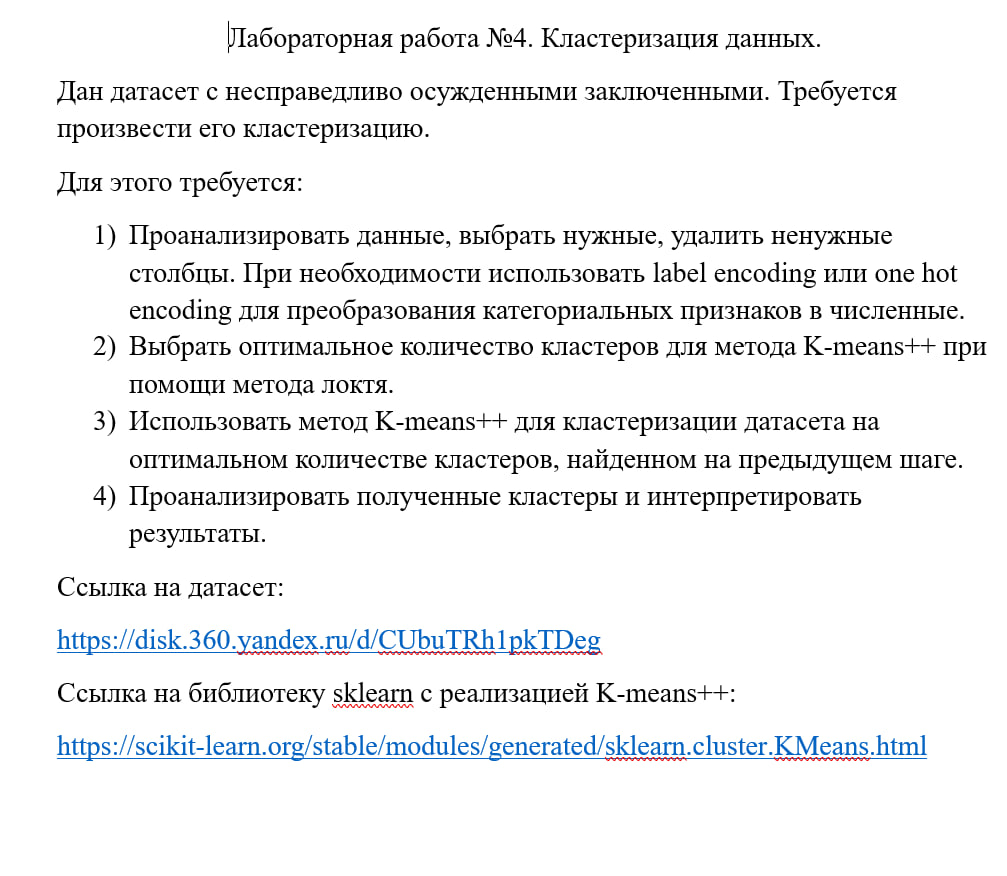

In [15]:
import pandas as pd

In [16]:
data = pd.read_csv("./data/wrong_conv_in_us.csv")

In [17]:
df = data.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          178 non-null    int64 
 1   Date of the Crime           178 non-null    int64 
 2   Defendants                  178 non-null    object
 3   Type of the Crime           178 non-null    object
 4   Location of the Crime       178 non-null    object
 5   Punishment for a crime      169 non-null    object
 6   Legally Exonerated          178 non-null    object
 7   Legally Exonerated Encoded  178 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 11.3+ KB


In [18]:
df.head(5)

,ID,Date of the Crime,Defendants,Type of the Crime,Location of the Crime,Punishment for a crime,Legally Exonerated,Legally Exonerated Encoded
0,0,1805,Dominic Daley and James Halligan,murder,Massachusetts,death,yes,1
1,1,1843,John Gordon,murder,Rhode Island,death,yes,1
2,2,1855,Chief Leschi,murder,Washington,death,no,0
3,3,1863,Chipita Rodriguez,murder,Texas,death,yes,1
4,4,1872,William Jackson Marion,murder,Nebraska,death,yes,1


In [19]:
X = df[["Legally Exonerated Encoded", "Type of the Crime"]].values

In [20]:
enc = ppc.OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False,
)

X["Type of the Crime_enc"] = enc.fit_transform(X["Type of the Crime"])

NameError: name 'ppc' is not defined

In [ ]:
X["Type of the Crime_enc"].head(5)